# 1. Užduotis

In [26]:
utils <- source("../src/utils.R")$value

library(latex2exp)

1. Kaip parinkote pradinį artinį?
2. Koks sprendimo būdas tinkamas, kai parametras yra neneigiamas,
   bet R optimizavimo funkcijoje nenumatyta galimybė nurodyti
   galimą parametrų kitimo sritį?
3. Kaip apibrėžiamas skirstinys, kuris priklauso tik nuo postūmio
   (location) ir mastelio (scale) parametrų?
4. Kaip apibrėžiamas skirstinys, kuris priklauso tik nuo mastelio
   (scale) ir formos parametrų (shape)?

Naudodami atvirkštinės transformacijos metodą, sumodeliuokite
atsitiktinio dydžio $T$, turinčio eksponentinį skirstinį su parametru
$\lambda$, t.y. a.d. $T$ pasiskirstymo funkcija yra

$$
F(t; \lambda) = 1 - e^{-\lambda t}, t \geq 0, \lambda > 0,
$$

didumo $n = 100$ paprastąją atsitiktinę imtį. Atlikite užduotis:

In [67]:
n <- 100
lambda <- 7 ## laisvai pasirinkta reikšmė

inverse_cdf <- function(theta) { ## exponential
    function(probs) {
        -1 / theta[1] * log(1 - probs)
    }
}
observ <- inverse_cdf(lambda)(runif(n))

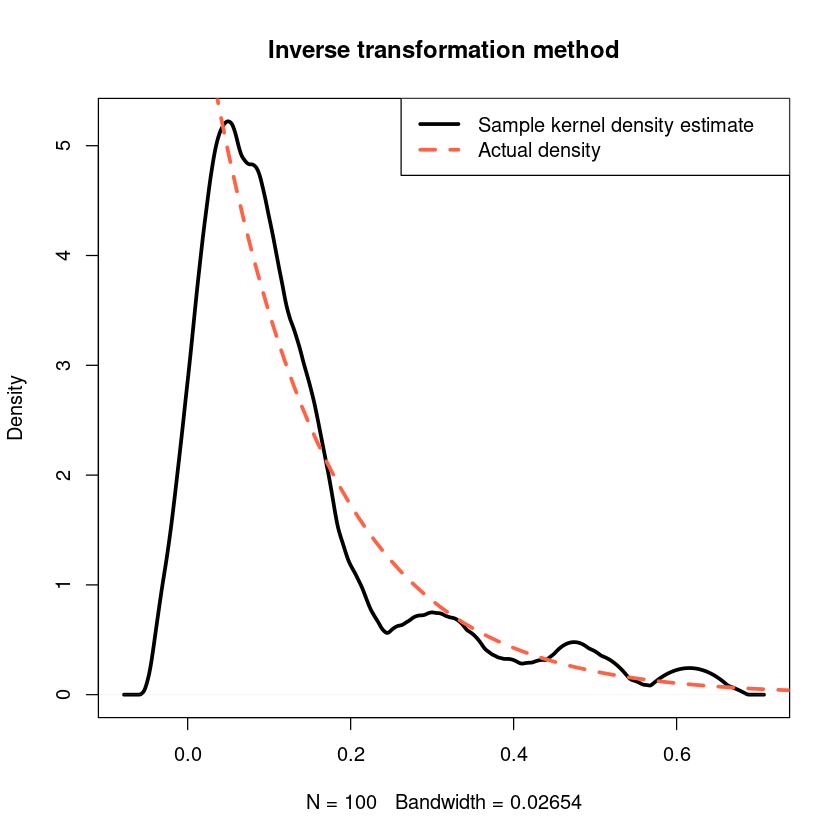

In [68]:
## Imties tankio įvertis
dens <- utils$kernel_density_estimate(observ)

## Teorinis tankis
lo <- qexp(0.001, lambda)
hi <- qexp(0.999, lambda)
x <- seq(lo, hi, length.out = 100)

plot(dens, main = "Inverse transformation method", col = "black", lwd = 3)
lines(x, dexp(x, lambda), col = "tomato", lwd = 3, lty = 2)
legend(
    "topright",
    legend = c("Sample kernel density estimate", "Actual density"),
    col = c("black", "tomato"),
    lty = c(1, 2),
    lwd = c(3, 3)
)

a) Naudodami R programos funkcijas maxLik ir optim, didžiausiojo
tikėtinumo metodu įvertinkite parametrą $\lambda$. Palyginkite su tikra
parametro reikšme.

**Logtikėtinumo funkcija yra:**

In [69]:
loglik <- function(observations) { ## exponential
    function(theta) {
        length(observations) * log(theta[1]) - theta[1] * sum(observations)
    }
}

**Pagalbinės funkcijos:**

In [70]:
optim_optimiser <- function(f, start) {
    mle <- stats::optim(
        start, f,
        method = "L-BFGS-B",
        control = list(fnscale = -1),
        hessian = TRUE
    )
    r <- list(
        estimates = mle$par,
        hessian = mle$hessian
    )
    return(r)
}

maxlik_optimiser <- function(f, start) {
    suppressPackageStartupMessages(require(maxLik))
    mle <- maxLik::maxLik(logLik = f, start = start)
    r <- list(
        estimates = coef(mle),
        hessian = hessian(mle)
    )
    return(r)
}

mle_estimator <- function(loglikelihood, optimiser) {
    function(data, start) {
        optimiser(loglikelihood(data), start)
    }
}

Pradiniams artiniams ieškoti naudosimės momentų metodu (parametrą perašysime kaip funkciją nuo vidurkio
ir įstatę imties vidurkį gausime įvertį):

In [71]:
(lambda_hat_moment <- 1 / mean(observ))

[1] 7.443381

**Vertinkime didžiausio tikėtinumo metodu:**

In [72]:
(lambda_hat_optim <- mle_estimator(loglik, optim_optimiser)(observ, c(lambda_hat_moment)))
(lambda_hat_maxlik <- mle_estimator(loglik, maxlik_optimiser)(observ, c(lambda_hat_moment)))

-1.804927


-1.733724


| Vertinimo metodas | $\hat{\lambda}$ |
| --- | --- |
| Momentų metodas | 7.44338083094512 |
| DT su `maxLik` | 7.44338083094577 |
| DT su `optim` | 7.44338082697687 |

b) Raskite parametrinį išgyvenimo funkcijos ($S(t) = 1 - F(t) = P(T > t)$)
įvertį. Nubraižykite grafiką, kuriame būtų pavaizduotas šis įvertis
ir teorinė išgyvenimo funkcija, suformuluokite išvadą.

In [73]:
survival_actual <- function(observ) {
    1 - pexp(observ, lambda)
}

survival_hat <- function(observ) {
    1 - pexp(observ, lambda_hat_optim$estimates[1])
}

**Brėžkime grafiką:** čia `x` iš aukščiau, kai brėžėme tankius.

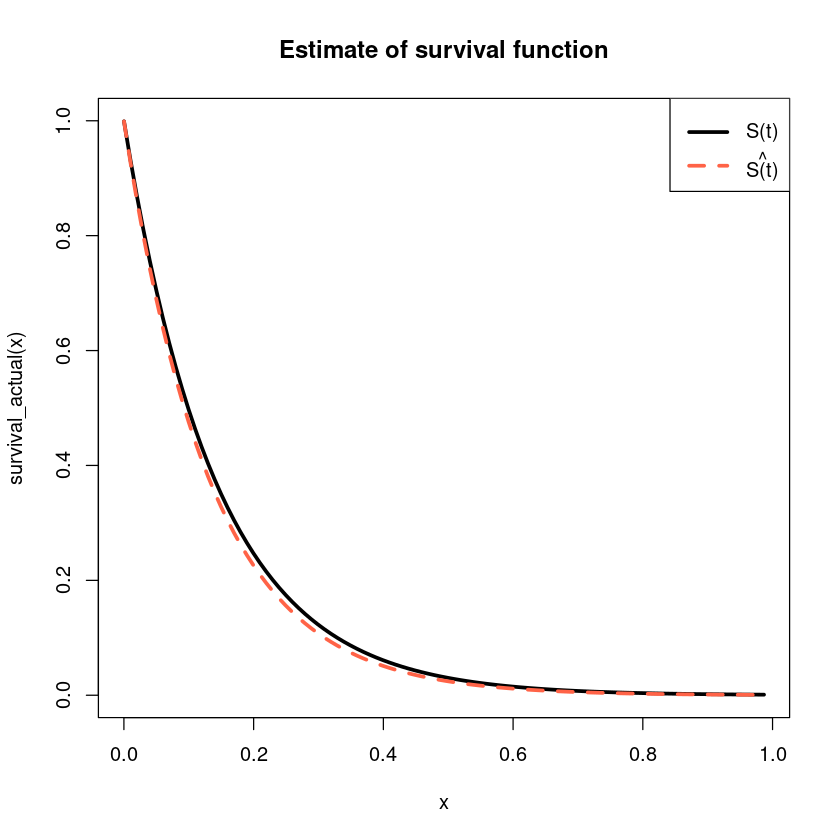

In [74]:
plot(x, survival_actual(x), main = "Estimate of survival function", col = "black", lwd = 3, type = "l")
lines(x, survival_hat(x), col = "tomato", lwd = 3, lty = 2)
legend(
    "topright",
    legend = c(TeX("S(t)"), TeX("\\hat{S(t)}")),
    col = c("black", "tomato"),
    lty = c(1, 2),
    lwd = c(3, 3)
)

Gerai įsižiūrėje, pastebėtume, kad funkcija šiek tiek nuvertinta šiuo atveju:

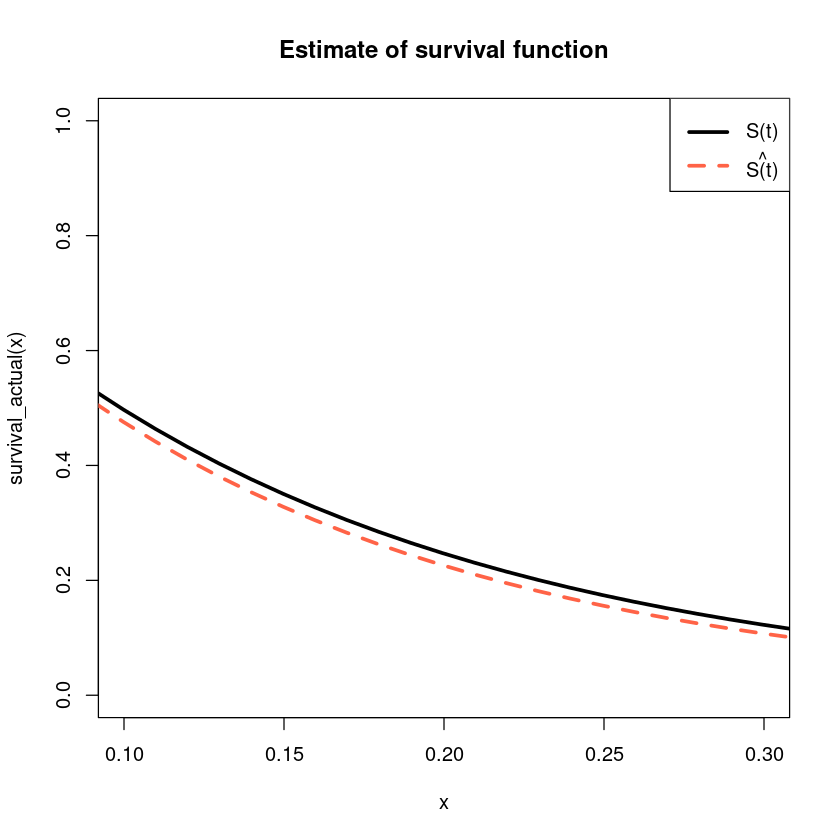

In [75]:
plot(x, survival_actual(x), main = "Estimate of survival function",
     col = "black", lwd = 3, type = "l",
     xlim = c(0.1, 0.3))
lines(x, survival_hat(x), col = "tomato", lwd = 3, lty = 2)
legend(
    "topright",
    legend = c(TeX("S(t)"), TeX("\\hat{S(t)}")),
    col = c("black", "tomato"),
    lty = c(1, 2),
    lwd = c(3, 3)
)

c) Raskite taškinį medianos įvertį. Palyginkite su tikra reikšme.

In [76]:
(median_actual <- qexp(0.5, lambda))
(median_hat <- qexp(0.5, lambda_hat_optim$estimates[1]))

[1] 0.09902103

[1] 0.09312263

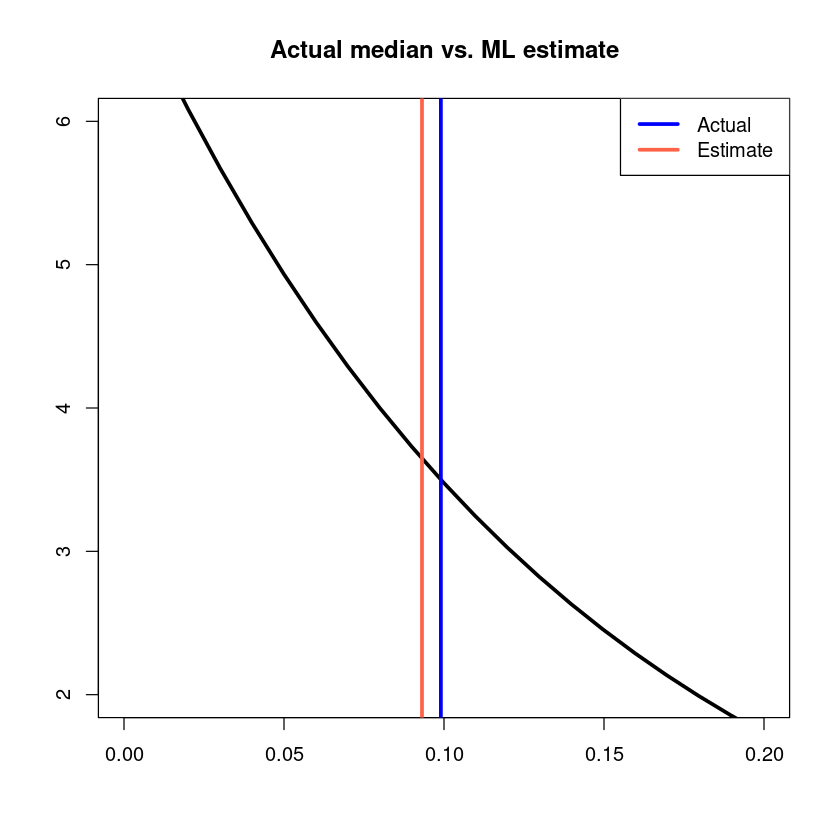

In [84]:
plot(x, dexp(x, lambda), main = "Actual median vs. ML estimate", col = "black",
     lwd = 3, type = "l",
     xlim = c(0, 0.2), ylim = c(2, 6),
     xlab = "", ylab = "")
abline(v = median_actual, lwd = 3, col = "blue")
abline(v = median_hat, lwd = 3, col = "tomato")
legend(
    "topright",
    legend = c("Actual", "Estimate"),
    col = c("blue", "tomato"),
    lwd = c(3, 3)
)